In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import os

In [ ]:
model_name = "EfficientNetB0"

DATA_DIR = "data"
TRAIN_DIR = os.path.join("..", DATA_DIR, "train")
VAL_DIR   = os.path.join("..", DATA_DIR, "valid")
TEST_DIR  = os.path.join("..", DATA_DIR, "test")

checkpoints_dir = Path(os.getcwd()).parent / "checkpoints" / model_name
checkpoints_dir.mkdir(parents=True, exist_ok=True)

CHECKPOINT_PATH_FE = os.path.join(checkpoints_dir, "best_effnet_b0_feature_extraction.weights.h5")
CHECKPOINT_PATH_FT = os.path.join(checkpoints_dir, "best_effnet_b0_fine_tuning.weights.h5")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
NUM_EPOCHS_FEATURE = 30
NUM_EPOCHS_FINE = 25
FINE_TUNE_LAYERS = 30   # عدد الطبقات الأخيرة التي سنفك تجميدها

In [44]:
preproc = tf.keras.applications.efficientnet.preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preproc,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.08,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preproc
)

train_gen = train_datagen.flow_from_directory(
    str(TRAIN_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_directory(
    str(VAL_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    str(TEST_DIR),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Classes:", class_names)


Found 2637 images belonging to 9 classes.
Found 760 images belonging to 9 classes.
Found 290 images belonging to 9 classes.
Classes: ['1', '10', '10 (new)', '100', '20', '20 (new)', '200', '5', '50']


In [45]:
y_train = train_gen.classes  # اخترناه من ال generator
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weight)

Class weights: {0: np.float64(4.883333333333334), 1: np.float64(0.9301587301587302), 2: np.float64(0.9242902208201893), 3: np.float64(0.9301587301587302), 4: np.float64(0.9099378881987578), 5: np.float64(0.846820809248555), 6: np.float64(0.9361022364217252), 7: np.float64(0.8772455089820359), 8: np.float64(0.9301587301587302)}


In [46]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base_model.trainable = False  # freeze base for feature extraction

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = inputs
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
x = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-3))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"]
)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,820 (16.71 MB)

 Trainable params: 330,249 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
callbacks_fe = [
    ModelCheckpoint(CHECKPOINT_PATH_FE, monitor="val_accuracy", mode='max', save_best_only=True, save_weights_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", mode='max', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_accuracy", mode='max', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

callbacks_ft = [
    ModelCheckpoint(CHECKPOINT_PATH_FT, monitor="val_accuracy", mode='max', save_best_only=True, save_weights_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", mode='max', patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_accuracy", mode='max', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

In [48]:
history_fe = model.fit(
    train_gen,
    epochs=NUM_EPOCHS_FEATURE,
    validation_data=val_gen,
    callbacks=callbacks_fe,
    class_weight=class_weight
)

Epoch 1/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3350 - loss: 2.2424
Epoch 1: val_accuracy improved from None to 0.72763, saving model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_feature_extraction.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.4547 - loss: 1.9505 - val_accuracy: 0.7276 - val_loss: 1.4218 - learning_rate: 0.0010
Epoch 2/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6506 - loss: 1.4742
Epoch 2: val_accuracy improved from 0.72763 to 0.82632, saving model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_feature_extraction.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6750 - loss: 1.4198 - val_accuracy: 0.8263 - val_loss: 1.1894 - learning_rate: 0.0010
Epoch 3/12
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7227 - loss: 1.2895
Epoch 3: val_accuracy improved from 0.82632 to 0.84211, 

In [49]:
base_model.trainable = True
# الحفاظ على طبقات مبكرة مجمّدة
if FINE_TUNE_LAYERS > 0:
    fine_at = len(base_model.layers) - FINE_TUNE_LAYERS
    for layer in base_model.layers[:fine_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_at:]:
        layer.trainable = True
else:
    # فك كل الطبقات
    for layer in base_model.layers:
        layer.trainable = True

# إعادة compile مع LR أصغر
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"]
)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,820 (16.71 MB)

 Trainable params: 1,826,409 (6.97 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

In [50]:
history_ft = model.fit(
    train_gen,
    epochs=NUM_EPOCHS_FINE,
    validation_data=val_gen,
    callbacks=callbacks_ft,
    class_weight=class_weight
)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6798 - loss: 1.3470
Epoch 1: val_accuracy improved from None to 0.90658, saving model to c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_fine_tuning.weights.h5
83/83 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7016 - loss: 1.2942 - val_accuracy: 0.9066 - val_loss: 0.8229 - learning_rate: 1.0000e-05
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7428 - loss: 1.2089
Epoch 2: val_accuracy did not improve from 0.90658
83/83 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.7490 - loss: 1.1777 - val_accuracy: 0.8921 - val_loss: 0.8641 - learning_rate: 1.0000e-05
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7900 - loss: 1.0843
Epoch 3: val_accuracy did not improve from 0.90658
83/83 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.7960 - loss: 1.0772 - val_accuracy: 0.8829 - val_loss: 0.8782 - learning_rate: 1.0000e-05
Epoch 4/20
83/83 ━

In [51]:
model.load_weights(CHECKPOINT_PATH_FT)
print(f"Loaded weights from {CHECKPOINT_PATH_FT}")

test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# توليد التنبؤات ومصفوفة الالتباس (اختياري)
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

# احفظ الموديل النهائي
model.save("effnet_b0_transfer_final.keras") 
print("Saved model to effnet_b0_transfer_final")

Loaded weights from c:\Users\user\1- Notebook\image\egyptian-new-currency-classifier\checkpoints\EfficientNetB0\best_effnet_b0_fine_tuning.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9172 - loss: 0.8054
Test Accuracy: 0.9172 | Test Loss: 0.8054
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step

Classification Report:
              precision    recall  f1-score   support

           1     0.9524    1.0000    0.9756        20
          10     0.8889    0.9143    0.9014        35
    10 (new)     0.9667    0.9667    0.9667        30
         100     0.9615    0.7143    0.8197        35
          20     0.9143    0.9143    0.9143        35
    20 (new)     0.9677    1.0000    0.9836        30
         200     0.9677    0.8571    0.9091        35
           5     0.8718    0.9714    0.9189        35
          50     0.8293    0.9714    0.8947        35

    accuracy                         0.9172       290
   macro avg     0.9245    0.9233    0.9204       290
weighted avg     0.921

In [52]:
def plot_training_curves(history, test_acc=0):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.axhline(y=test_acc, linestyle='--', color='green', label=f'Test Acc: {test_acc:.2f}')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

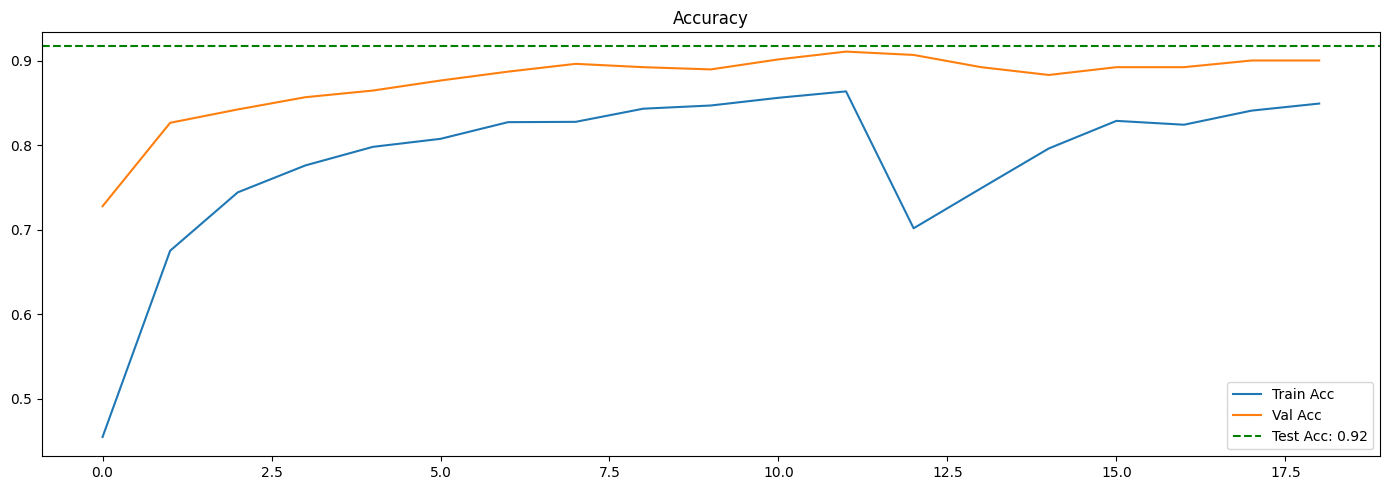

In [53]:
# Combine training histories for complete visualization
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return type('History', (), {'history': combined})()

full_history = combine_histories(history_fe, history_ft)
plot_training_curves(full_history, test_acc=test_acc)